# 6自由度アクティブ防振装置のアクティブダンピング (非コロケート配置)

このチュートリアルでは、`gwexpy` と `python-control` を組み合わせて、多自由度（MIMO）システムのシミュレーション、システム同定、そして制御系設計を行う一連の流れを実演します。

**シナリオ:**
3つの足で支持された正三角形の防振台（6自由度剛体）を想定します。
今回は、**アクチュエータとセンサーの位置が異なる（非コロケート）** 構成を扱います。
*   **アクチュエータ**: 3つの足の位置（支持点）に設置 ($0^\circ, 120^\circ, 240^\circ$)
*   **センサー**: 足と足の中間地点に設置 ($60^\circ, 180^\circ, 300^\circ$)

このように入出力位置がずれている場合、単純な各軸独立制御ではうまくいかないため、**モード空間（Modal Space）** での制御器設計を行います。

**ステップ:**
1.  **物理モデルの構築**: センサー・アクチュエータ配置を考慮した状態空間モデルを作成します。
2.  **MIMO伝達関数の測定**: `FrequencySeriesMatrix` で非対角成分を含む伝達関数行列を可視化します。
3.  **システム同定**: 物理パラメータと幾何学配置から制御用モデルを定義します。
4.  **ダンピング制御器の設計**: センサー信号をモード座標に変換し、モードごとにダンピングをかける「モード制御」を設計します。
5.  **閉ループ検証**: インパルス応答とASD比較により制振性能を確認します。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control
from scipy import signal

from gwexpy import TimeSeries, TimeSeriesDict
from gwexpy.frequencyseries import FrequencySeriesMatrix

## 1. 6自由度アクティブ防振装置のシミュレーション (Plant Model)

剛体の運動方程式 $M \ddot{q} + C \dot{q} + K q = F$ を定義します。
ここでは垂直3自由度（$z, \theta_x, \theta_y$）に焦点を当てます。

**座標変換:**
モード座標 $q = [z, \theta_x, \theta_y]^T$ に対し、
*   アクチュエータ物理座標 $p_{act}$: $0^\circ, 120^\circ, 240^\circ$
*   センサー物理座標 $p_{sen}$: $60^\circ, 180^\circ, 300^\circ$

それぞれの変換行列 $T_{act}, T_{sen}$ を定義し、状態空間モデルに組み込みます。


In [2]:
# 物理パラメータ
m = 100.0       # 質量 [kg]
I_x = 20.0      # 慣性モーメント [kg m^2]
I_y = 20.0

# 支持バネ・ダンパ (アクチュエータ位置 = 足の位置)
k_leg = 2000.0  # バネ定数 [N/m]
c_leg = 0.20    # 減衰係数 [N s/m]

# ジオメトリ: 半径R
R = 0.5         # [m]

# 角度設定 (deg -> rad)
deg2rad = np.pi / 180.0
# アクチュエータ: 足の位置
angles_act = np.array([0, 120, 240]) * deg2rad
# センサー: 足の間
angles_sen = np.array([60, 180, 300]) * deg2rad

# 座標変換行列の作成関数
# p = T * q  =>  [z_i] = [1, R*sin(th), -R*cos(th)] @ [z, tx, ty]
def make_transform_matrix(angles, radius):
    T = np.zeros((3, 3))
    for i, ang in enumerate(angles):
        T[i, 0] = 1.0
        T[i, 1] = radius * np.sin(ang)
        T[i, 2] = -radius * np.cos(ang)
    return T

T_act = make_transform_matrix(angles_act, R)
T_sen = make_transform_matrix(angles_sen, R)

print("Actuator Transform Matrix T_act:")
print(np.round(T_act, 2))
print("Sensor Transform Matrix T_sen:")
print(np.round(T_sen, 2))

# モーダル空間での M, K, C 行列
M_modal = np.diag([m, I_x, I_y])

# 物理空間(足位置)での K, C
K_phys = np.diag([k_leg, k_leg, k_leg])
C_phys = np.diag([c_leg, c_leg, c_leg])

# モーダル空間へ投影: K_modal = T_act.T * K_phys * T_act
# (バネ・ダンパは足の位置にあるため T_act を使用)
K_modal = T_act.T @ K_phys @ T_act
C_modal = T_act.T @ C_phys @ T_act

# 状態空間モデルの作成
# x = [q, q_dot]^T
A_sys = np.block([
    [np.zeros((3, 3)), np.eye(3)],
    [-np.linalg.inv(M_modal) @ K_modal, -np.linalg.inv(M_modal) @ C_modal]
])
B_sys_modal = np.block([
    [np.zeros((3, 3))],
    [np.linalg.inv(M_modal)]
])
C_sys_modal = np.block([np.eye(3), np.zeros((3, 3))])
D_sys = np.zeros((3, 3))

# 入出力を物理座標に変換
# Input: Actuator Forces u (at angles_act) -> Generalized Force Q = T_act.T * u
# Output: Sensor Displacements y (at angles_sen) -> y = T_sen * q
B_sys = B_sys_modal @ T_act.T
C_sys = T_sen @ C_sys_modal

sys = control.StateSpace(A_sys, B_sys, C_sys, D_sys,
                         inputs=["ACT1", "ACT2", "ACT3"],
                         outputs=["SEN1", "SEN2", "SEN3"])
print(sys)


Actuator Transform Matrix T_act:
[[ 1.    0.   -0.5 ]
 [ 1.    0.43  0.25]
 [ 1.   -0.43  0.25]]
Sensor Transform Matrix T_sen:
[[ 1.    0.43 -0.25]
 [ 1.    0.    0.5 ]
 [ 1.   -0.43 -0.25]]
<StateSpace>: sys[0]
Inputs (3): ['ACT1', 'ACT2', 'ACT3']
Outputs (3): ['SEN1', 'SEN2', 'SEN3']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00
       1.00000000e+00  0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  1.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  0.00000000e+00  1.00000000e+00]
     [-6.00000000e+01 -3.33955086e-15 -2.16715534e-15
      -6.00000000e-03 -3.68259567e-19 -2.35922393e-19]
     [-1.70530257e-14 -3.75000000e+01  9.61481343e-15
      -2.08166817e-18 -3.75000000e-03  9.61481343e-19]
     [-1.13686838e-14  9.93438680e-15 -3.75000000e+01
      -1.04083409e-18  9.61481343e-19 -3.75000000e-

## 2. MIMO伝達関数の測定

センサーとアクチュエータの位置が異なるため、対角成分（ACT1->SEN1）だけでなく、非対角成分にも強い応答が現れるはずです。


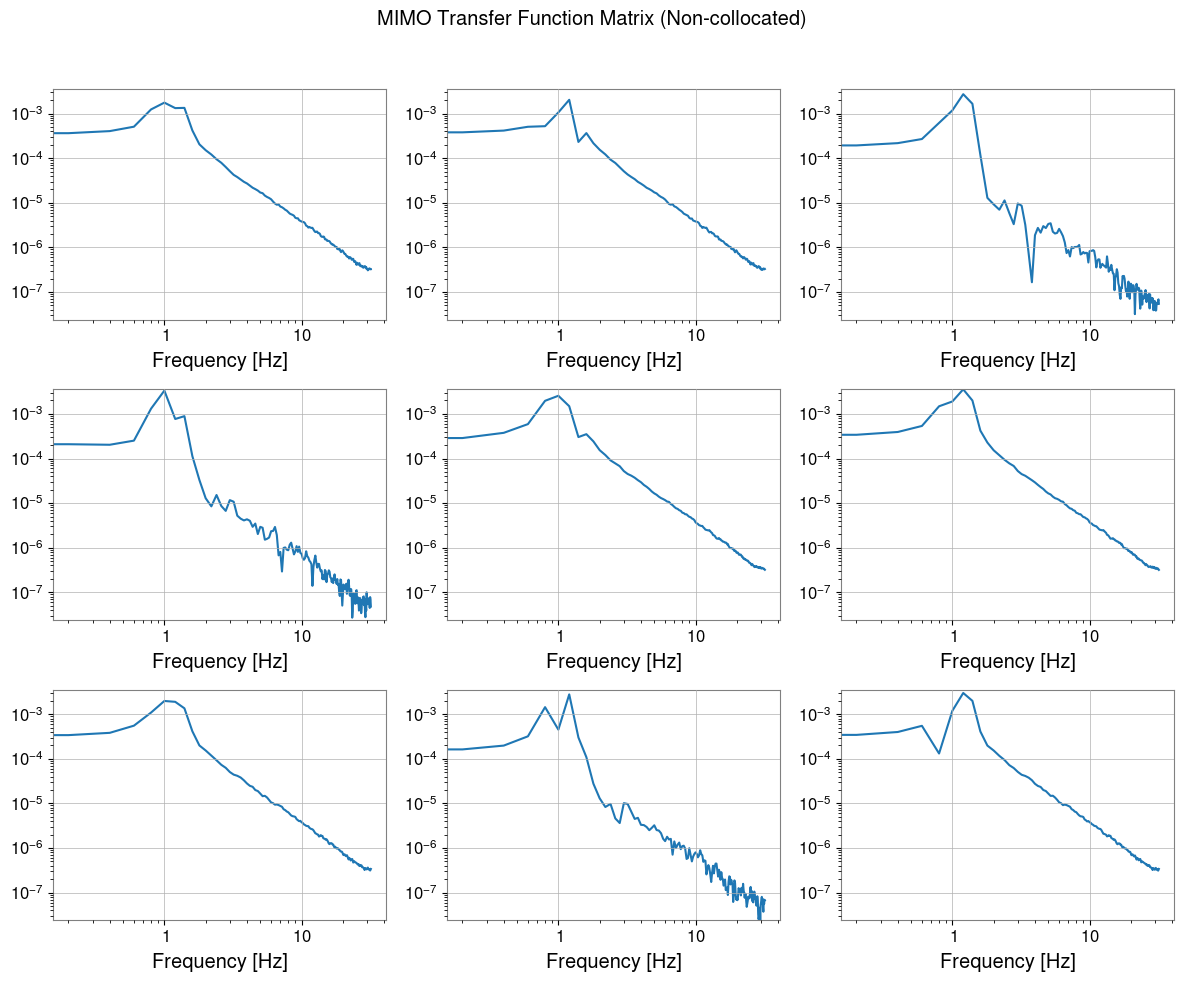

In [3]:
fs = 64
duration = 1024.0
t = np.arange(0, duration, 1/fs)
n_samples = len(t)

# 入力信号: 3ch ホワイトノイズ
np.random.seed(0)
u_data = np.random.normal(0, 1.0, (3, n_samples))

# 時間応答
time_response = control.forced_response(sys, T=t, U=u_data)

# gwexpy TimeSeriesDict
tsd_input = TimeSeriesDict({f"ACT{i+1}":TimeSeries(u_data[i],
                                                   t0=0,
                                                   sample_rate=fs,
                                                   name=f"Actuator {i+1}",
                                                   unit="N")
                            for i in range(3)})

tsd_output = TimeSeriesDict.from_control(time_response, unit="m")
for i in range(3):
    tsd_output[f"SEN{i+1}"].name = f"Sensor {i+1}"

# MIMO TF 計算
tfs = [[tsd_input[f"ACT{j+1}"].transfer_function(tsd_output[f"SEN{i+1}"], fftlength=5)
        for j in range(3)] for i in range(3)]

tf_matrix = FrequencySeriesMatrix([[tf.value for tf in row] for row in tfs],
                                  frequencies=tfs[0][0].frequencies)

tf_data = tf_matrix.value
freqs = tf_matrix.frequencies

# plot
tf_matrix.abs().plot(figsize=(12, 10), xscale="log", yscale="log").suptitle("MIMO Transfer Function Matrix (Non-collocated)\n\n")
plt.tight_layout()
plt.show()


## 3 & 4. モード制御系の設計 (Modal Control Design)

アクチュエータとセンサーの位置が一致していないため、単純な分散制御（$F_i \propto \dot{y}_i$）では不安定になる恐れがあります。
そこで、**座標変換行列を用いてセンサー信号からモード変位を推定し、モード空間でダンピングをかけた後、アクチュエータ推力に分配する** 手法を採ります。

**制御フロー:**
1.  **Sensing**: センサー出力 $y$ からモード変位 $q$ を推定
    $$ q_{est} = T_{sen}^{-1} y $$
2.  **Modal Damping**: モードごとに擬似微分フィルタ $K(s)$ を適用し、モード力 $F_{modal}$ を計算
    $$ F_{modal} = -K_{modal}(s) q_{est} $$
3.  **Actuation**: モード力 $F_{modal}$ をアクチュエータ推力 $u$ に分配
    $$ u = (T_{act}^T)^{-1} F_{modal} $$

全体として、コントローラ $K_{MIMO}$ は以下のようになります。
$$ K_{MIMO}(s) = (T_{act}^T)^{-1} \cdot \mathrm{diag}(K_{z}(s), K_{\theta x}(s), K_{\theta y}(s)) \cdot T_{sen}^{-1} $$


In [4]:
# --- 1. Sensing & Actuation Matrix の準備 ---
# 推定モデルに基づいて変換行列を用意します（ここでは真値を使用）
# Sensing Matrix: y -> q
S_sensing = np.linalg.inv(T_sen)

# Actuation Matrix: F_modal -> u
# F_modal = T_act.T * u  =>  u = inv(T_act.T) * F_modal
D_actuation = np.linalg.inv(T_act.T)

print("Sensing Matrix (Sensor -> Mode):")
print(np.round(S_sensing, 2))
print("Actuation Matrix (Mode Force -> Actuator):")
print(np.round(D_actuation, 2))

# --- 2. Modal Damping Filter Design ---
# 各モードに対してダンピングゲインを設定
# 並進モード(z)と回転モード(tx, ty)でゲインを変えることも可能ですが、
# ここでは簡単のためすべて同じゲイン・フィルタとします。
gain = 1000.0  # Modal Damping Gain
fc_l = 0.1
fc_h = 20.0
w_l = 2 * np.pi * fc_l
w_h = 2 * np.pi * fc_h

s = control.tf('s')
K_filter = gain * s / ((1 + s/w_l) * (1 + s/w_h))

# 対角行列化 (3モード分)
K_modal_diag = []
for _ in range(3):
    K_modal_diag.append(control.ss(K_filter))

# control.append は対角ブロック結合をするが、入出力数が変わるため注意が必要。
# ここでは手動で状態空間モデルを結合するより、
# python-control の演算機能を使って K_MIMO を構築します。

# K_modal_block: 3-input 3-output Diagonal System
#  [ K_f  0    0   ]
#  [ 0    K_f  0   ]
#  [ 0    0    K_f ]
K_modal_block = control.append(K_modal_diag[0], K_modal_diag[1], K_modal_diag[2])


# --- 3. MIMO Controller Construction ---
# K_MIMO = D_actuation * K_modal_block * S_sensing
# python-control では定数行列とSSの積はそのまま書けます

# S_sensing (Static Gain) * y
# K_modal_block * (S_sensing * y)
# D_actuation * (K_modal_block * S_sensing * y)

# Note: 行列積の順序に注意。Control object の乗算は直列結合。
# Sys2 * Sys1 は Out <--- Sys2 <--- Sys1 <--- In
# 数式: u = D * K * S * y
# Code: K_mimo = D * K * S
# しかし D, S は numpy array。control.ss(D) などで変換が必要。

K_mimo = D_actuation * K_modal_block * S_sensing

print("MIMO Controller States:", K_mimo.nstates)


Sensing Matrix (Sensor -> Mode):
[[ 0.33  0.33  0.33]
 [ 1.15 -0.   -1.15]
 [-0.67  1.33 -0.67]]
Actuation Matrix (Mode Force -> Actuator):
[[ 0.33 -0.   -1.33]
 [ 0.33  1.15  0.67]
 [ 0.33 -1.15  0.67]]
MIMO Controller States: 6


## 5 & 6. 閉ループ検証 (インパルス応答 & ASD)

構築したモード制御系を用いて、閉ループシミュレーションを行います。
アクチュエータ1へのインパルス外乱、および全軸への定常地面振動に対する応答を確認します。


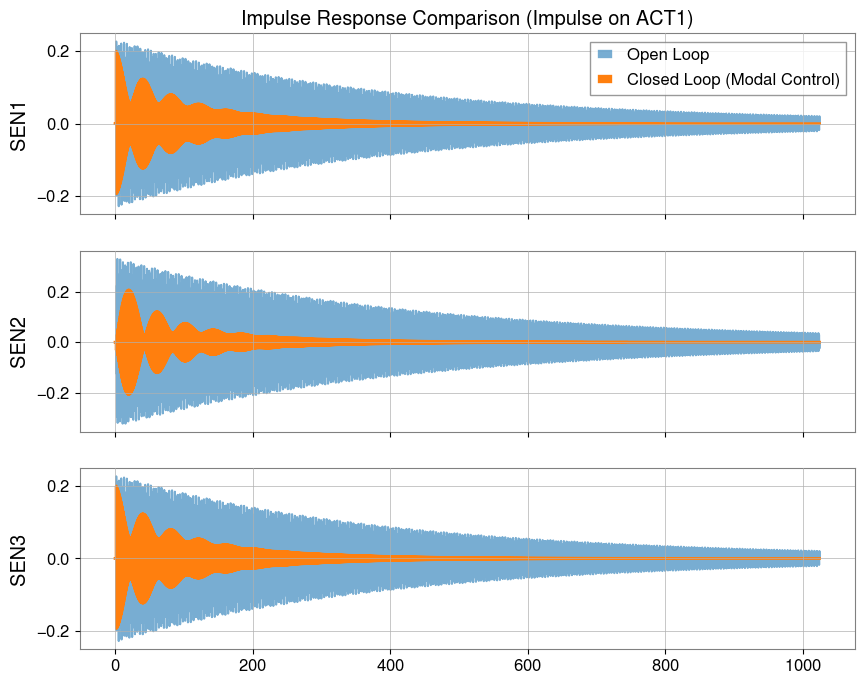

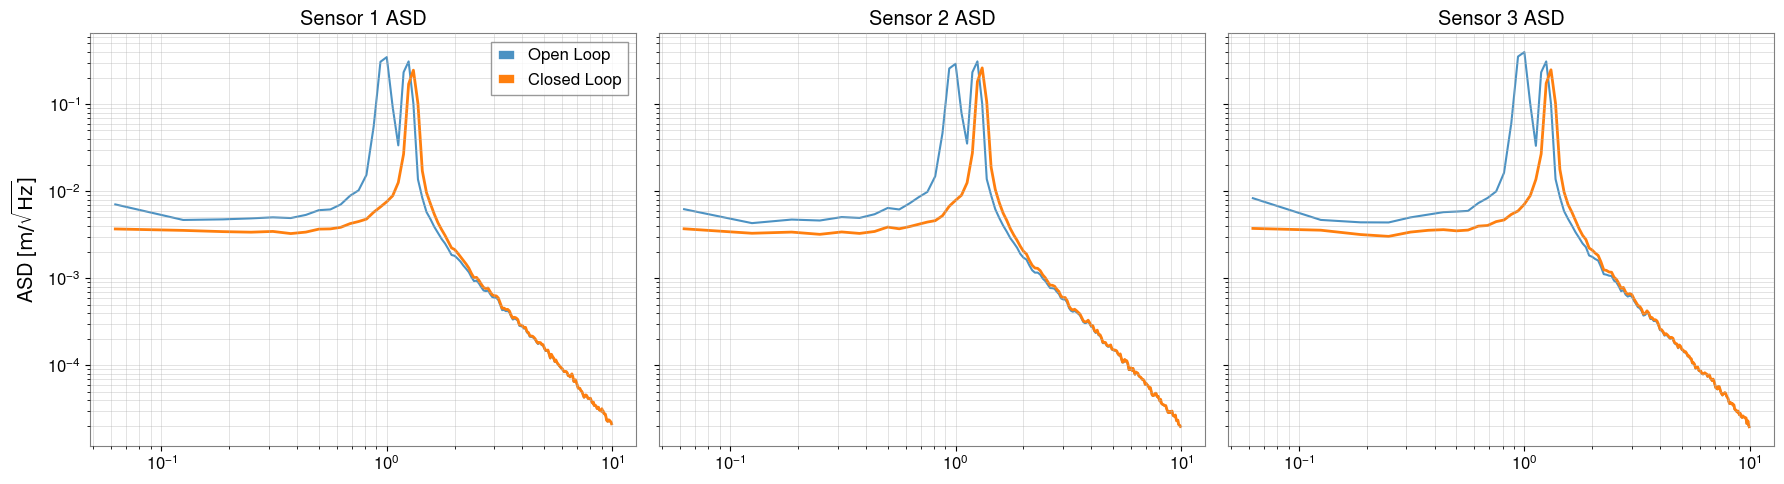

In [5]:
# 閉ループシステム
sys_cl = control.feedback(sys, K_mimo, sign=-1)

# --- Impulse Response ---
u_impulse = np.zeros((3, n_samples))
u_impulse[0, 100] = 100.0 * fs # Impulse on Actuator 1

resp_ol = control.forced_response(sys, T=t, U=u_impulse)
resp_cl = control.forced_response(sys_cl, T=t, U=u_impulse)

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    ax = axes[i]
    ax.plot(t, resp_ol.outputs[i], label="Open Loop", alpha=0.6)
    ax.plot(t, resp_cl.outputs[i], label="Closed Loop (Modal Control)", linewidth=2)
    ax.set_ylabel(f"SEN{i+1}")
    ax.grid(True)
    if i == 0: ax.legend(loc="upper right")
axes[0].set_title("Impulse Response Comparison (Impulse on ACT1)")
plt.show()

# --- ASD Comparison ---
# Ground Vibration Simulation
np.random.seed(42)
wn = np.random.normal(0, 1.0, (3, n_samples))
b, a = signal.butter(1, 5.0, fs=fs, btype='low')
dist = signal.lfilter(b, a, wn) * 50.0

resp_ol_noise = control.forced_response(sys, T=t, U=dist)
resp_cl_noise = control.forced_response(sys_cl, T=t, U=dist)

tsd_ol = TimeSeriesDict.from_control(resp_ol_noise)
for i in range(3):
    tsd_ol[list(tsd_ol.keys())[i]].name = f"SEN{i+1}"
tsd_ol = TimeSeriesDict({ts.name: ts for ts in tsd_ol.values()})
tsd_cl = TimeSeriesDict.from_control(resp_cl_noise)
for i in range(3):
    tsd_cl[list(tsd_cl.keys())[i]].name = f"SEN{i+1}"
tsd_cl = TimeSeriesDict({ts.name: ts for ts in tsd_cl.values()})

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i in range(3):
    ax = axes[i]
    asd_ol = tsd_ol[f"SEN{i+1}"].asd(fftlength=16, overlap=8, method="welch").crop(0.1,10)
    asd_cl = tsd_cl[f"SEN{i+1}"].asd(fftlength=16, overlap=8, method="welch").crop(0.1,10)

    ax.loglog(asd_ol, label="Open Loop", alpha=0.8)
    ax.loglog(asd_cl, label="Closed Loop", linewidth=2)
    ax.set_title(f"Sensor {i+1} ASD")
    ax.grid(True, which="both", alpha=0.5)
    if i==0:
        ax.set_ylabel(r"ASD [$\mathrm{m}/\sqrt{\mathrm{Hz}}$]")
        ax.legend()
plt.tight_layout()
plt.show()

# センサーとアクチュエータの位置が異なっていても、
# 適切なモード座標変換を行うことで有効なダンピングが得られています。
